# CNN image classification
## What is a classification problem?

A [classification problem](https://en.wikipedia.org/wiki/Statistical_classification) involves predicting whether something is one thing or another.

For example, you might want to:

| Problem type | What is it? | Example |
| ----- | ----- | ----- |
| **Binary classification** | Target can be one of two options, e.g. yes or no | Predict whether or not someone has heart disease based on their health parameters. |
| **Multi-class classification** | Target can be one of more than two options | Decide whether a photo of is of food, a person or a dog. |
| **Multi-label classification** | Target can be assigned more than one option | Predict what categories should be assigned to a Wikipedia article (e.g. mathematics, science & philosohpy). |

---

<div align="center">
<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/02-different-classification-problems.png" alt="various different classification in machine learning such as binary classification, multiclass classification and multilabel classification" width=900/>
</div>

## Datasets
Dogs vs Cats 데이터 세트는 개와 고양이로 구성되어있는 이진 분류 데이터세트 입니다.
![image](https://production-media.paperswithcode.com/datasets/Screenshot_2021-09-16_at_10-07-46_512467_1_En_7_Chapter_Author_pdf.png)

# PyTorch Workflow

| **Topic** | **Contents** |
| ----- | ----- |
| **1. Getting data ready** | Data can be almost anything but to get started we're going to create a simple straight line |
| **2. Building a model** | Here we'll create a model to learn patterns in the data, we'll also choose a **loss function**, **optimizer** and build a **training loop**. |
| **3. Fitting the model to data (training)** | We've got data and a model, now let's let the model (try to) find patterns in the (**training**) data. |
| **4. Making predictions and evaluating a model (inference)** | Our model's found patterns in the data, let's compare its findings to the actual (**testing**) data. |

In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


# 0. Libraries
## 라이브러리 가져오기

모듈이란 함수나 변수 또는 클래스를 모아 놓은 파일입니다. 모듈은 다른 파이썬 프로그램에서 불러와 사용할 수 있게끔 만든 파이썬 파일이라고도 할 수 있습니다.

| PyTorch module | What does it do? |
| ----- | ----- |
| [`torchvision`](https://pytorch.org/vision/stable/index.html) | Contains datasets, model architectures and image transformations often used for computer vision problems. |
| [`torchvision.datasets`](https://pytorch.org/vision/stable/datasets.html) | Here you'll find many example computer vision datasets for a range of problems from image classification, object detection, image captioning, video classification and more. It also contains [a series of base classes for making custom datasets](https://pytorch.org/vision/stable/datasets.html#base-classes-for-custom-datasets). |
| [`torchvision.models`](https://pytorch.org/vision/stable/models.html) | This module contains well-performing and commonly used computer vision model architectures implemented in PyTorch, you can use these with your own problems. |
| [`torchvision.transforms`](https://pytorch.org/vision/stable/transforms.html) | Often images need to be transformed (turned into numbers/processed/augmented) before being used with a model, common image transformations are found here. |
| [`torch.utils.data.Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) | Base dataset class for PyTorch.  |
| [`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html#module-torch.utils.data) | Creates a Python iteralbe over a dataset (created with `torch.utils.data.Dataset`). |

In [ ]:
from collections import defaultdict
import copy
import random
import os
import shutil
from tqdm import tqdm
import cv2
from urllib.request import urlretrieve

from torch.utils.data import Dataset, DataLoader, ConcatDataset, Subset
from torchvision import datasets
from torchvision import transforms as T

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import numpy as np
import collections
import matplotlib.pyplot as plt
%matplotlib inline

# 1. Load data
### 데이터 세트 다운로드 및 압축해제


In [ ]:
class TqdmUpTo(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)

def download_url(url, filepath):
    directory = os.path.dirname(os.path.abspath(filepath))
    os.makedirs(directory, exist_ok=True)
    if os.path.exists(filepath):
        print("Filepath already exists. Skipping download.")
        return

    with TqdmUpTo(unit="B", unit_scale=True, unit_divisor=1024, miniters=1, desc=os.path.basename(filepath)) as t:
        urlretrieve(url, filename=filepath, reporthook=t.update_to, data=None)
        t.total = t.n

def extract_archive(filepath):
    extract_dir = os.path.dirname(os.path.abspath(filepath))
    shutil.unpack_archive(filepath, extract_dir)

In [ ]:
dataset_directory = os.path.join("./datasets/cats-vs-dogs")

In [ ]:
filepath = os.path.join(dataset_directory, "cats_and_dogs_filtered.zip")
download_url(
    url="https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip",
    filepath=filepath,
)

extract_archive(filepath)

cats_and_dogs_filtered.zip: 100%|██████████| 65.4M/65.4M [00:00<00:00, 79.6MB/s]


## 데이터 로더 정의

데이터 로더(Data Loader)는 한번에 많은 양의 데이터를 불러올 수없기 때문에, 한번에 다 부르지 않고, 조금씩 불러서 사용하는 방법입니다.




In [ ]:
train_transform = T.Compose([
                            T.Resize((64, 64)), # Resize the input image to the given size.
                            T.RandomRotation(15), # Rotate the image by angle.
                            T.RandomAffine( # Random affine transformation of the image keeping center invariant.
                                degrees=0,
                                translate=(0.01, 0.12),
                                shear=(0.01, 0.03),),
                            T.RandomHorizontalFlip(), # Horizontally flip the given image randomly with a given probability.
                            T.ToTensor(), # Convert a PIL Image or numpy.ndarray to tensor.
])

test_transform = T.Compose([
                            T.Resize((64, 64)),
                            T.ToTensor(),
])

train_path = dataset_directory + '/cats_and_dogs_filtered/train'
test_path = dataset_directory + '/cats_and_dogs_filtered/validation'
train_datasets = datasets.ImageFolder(train_path, transform=train_transform)
test_datasets = datasets.ImageFolder(test_path, transform=test_transform )

![image](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/03-computer-vision-input-and-output-shapes.png)

In [ ]:
image, label = train_datasets[0]
print(image)
print(label)
print(image.shape)

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.6980, 0.7020, 0.6902,  ..., 0.1765, 0.0000, 0.0000],
         [0.6902, 0.6980, 0.6902,  ..., 0.1569, 0.0000, 0.0000],
         [0.6863, 0.6902, 0.6902,  ..., 0.1451, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.5529, 0.5569, 0.5490,  ..., 0.1294, 0.0000, 0.0000],
         [0.5451, 0.5529, 0.5490,  ..., 0.1255, 0.0000, 0.0000],
         [0.5412, 0.5451, 0.5490,  ..., 0.1137, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.

### 배치(Batch)

배치(Batch)는 가중치를 한 번 업데이트하는 데 한 개 이상의 훈련 데이터를 사용하는 부분입니다. 그리고 이 집합에 포함하는 데이터의 양을 배치 크기라고 부릅니다.

![image](http://t1.kakaocdn.net/braincloud/homepage/article_image/820bc25e-dd76-493d-a6a9-4f8d357dce90.png)

---

### 데이터 순회

`torch.utils.data.DataLoader`를 사용하면 데이터를 순회할 수 있습니다.

* `batch_size` : 배치의 크기
* `shuffle` : 매 에폭 마다 데이터를 랜덤하게 섞습니다.

In [ ]:
batch_size = 32

train_loader = torch.utils.data.DataLoader(train_datasets, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_datasets, batch_size=batch_size, shuffle=False)

print(f'number of train dataset: {len(train_loader.dataset)}')
print(f'number of test datset: {len(test_loader.dataset)}')

number of train dataset: 2000
number of test datset: 1000


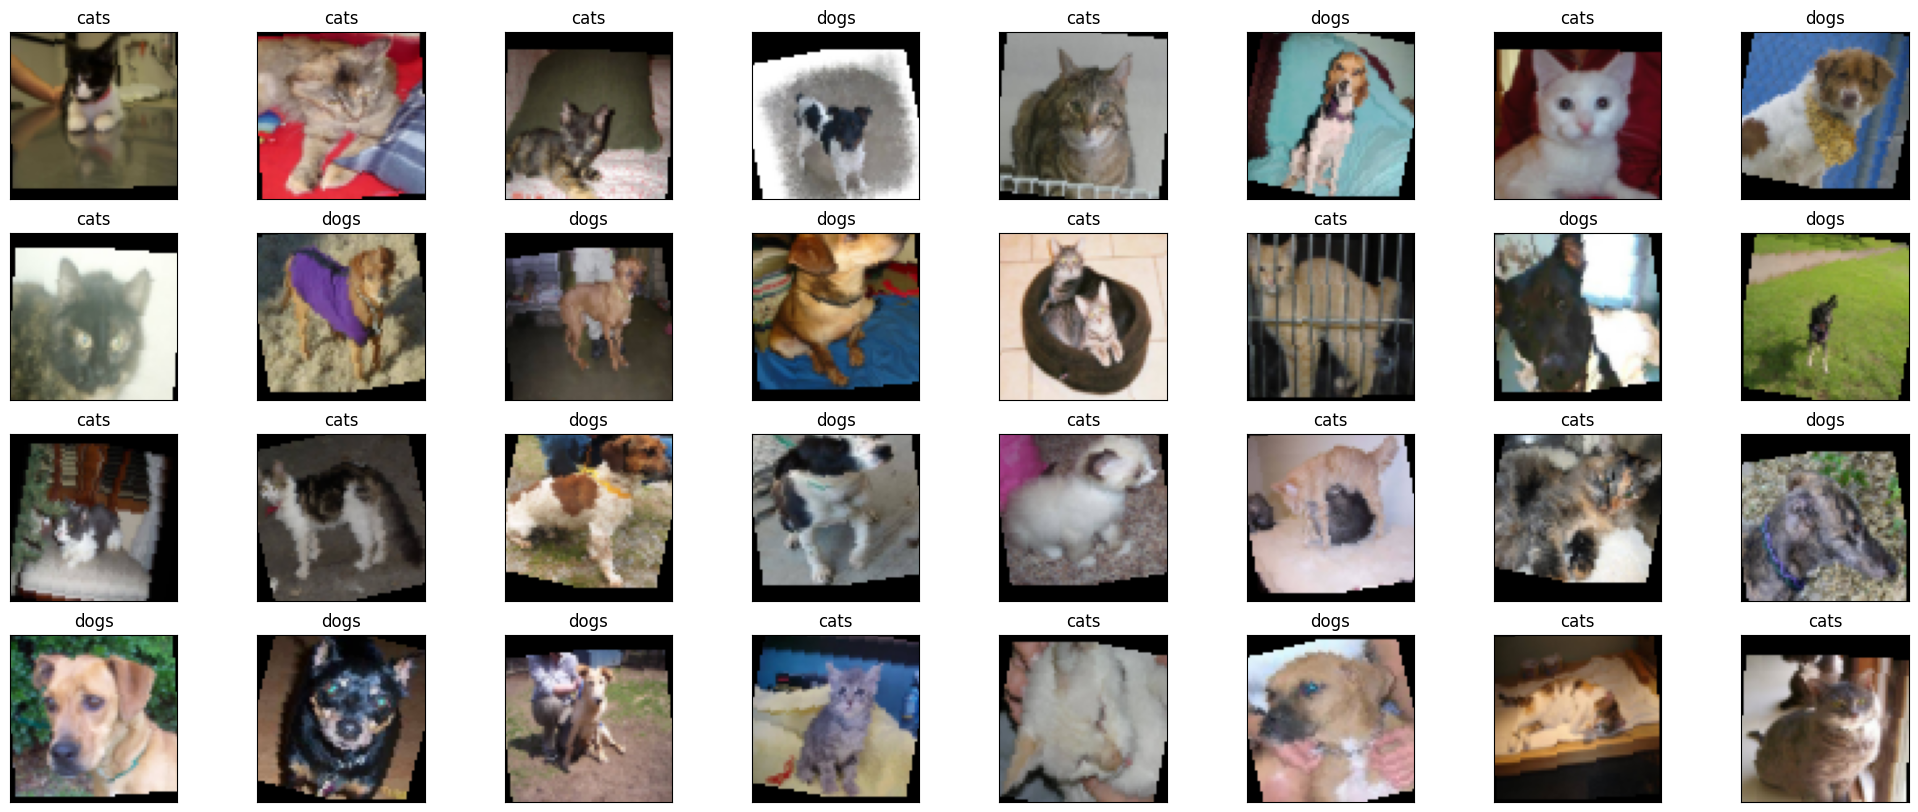

In [ ]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 10))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(4, batch_size//4, idx+1, xticks=[], yticks=[])

    ax.imshow(images[idx].transpose(1, 2, 0))
    ax.set_title(train_datasets.classes[labels[idx]])

## 합성곱 신경망(Convolution Neural Network) 정의
[CNN Explainer](https://poloclub.github.io/cnn-explainer/)

CNN에는 피쳐 추출을 위한 Convolution 모듈(Convolution + ReLU + pooling)과 분류를 위한 Fully connected layer가 있습니다.

![image](https://developers.google.com/machine-learning/practica/image-classification/images/cnn_architecture.svg?hl=ko-KR)

We could start using our model above and see what happens but let's first step through the two new layers we've added:
* [`nn.Conv2d()`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html), also known as a convolutional layer.
* [`nn.MaxPool2d()`](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html), also known as a max pooling layer.

*Example of what happens when you change the hyperparameters of a `nn.Conv2d()` layer.*

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # 이미지의 입력은 (3, 64, 64)
        # 이미지는 RGB 3채널을 가지므로 in_channels=3
        # 3x3 사각형 커널(필터) 사용
        # (64 - 3) / 1 + 1 = 62
        # 풀링 레이어를 거치면 (16, 31, 31)

        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=3, #(16, 62, 62)
                      out_channels=16,
                      kernel_size=3, # how big is the square that's going over the image?
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU6(inplace=True),
            nn.MaxPool2d(2, 2) # (16, 31, 31)
            )

        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3), # (32, 29, 29)
            nn.ReLU6(inplace=True),
            nn.MaxPool2d(2, 2) # (32, 14, 14)
        )

        self.block_3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3), # (64, 12, 12)
            nn.ReLU6(inplace=True),
            nn.MaxPool2d(2, 2) # (64, 6, 6)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 6 * 6, 512),
            nn.Linear(512, 512),
            nn.Linear(512, 1)
        )

    def forward(self, x):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.classifier(x)

        return x

net = Net()

## `nn.Conv2d()` 단계별 실행

`nn.Conv2d()` with various parameters:
* `in_channels` (int) - Number of channels in the input image.
* `out_channels` (int) - Number of channels produced by the convolution.
* `kernel_size` (int or tuple) - Size of the convolving kernel/filter.
* `stride` (int or tuple, optional) - How big of a step the convolving kernel takes at a time. Default: 1.
* `padding` (int, tuple, str) - Padding added to all four sides of input. Default: 0.

https://poloclub.github.io/cnn-explainer/

In [ ]:
torch.manual_seed(42)

# Create sample batch of random numbers with same size as image batch
images = torch.randn(size=(32, 3, 64, 64)) # [batch_size, color_channels, height, width]
test_image = images[0] # get a single image for testing
print(f"Image batch shape: {images.shape} -> [batch_size, color_channels, height, width]")
print(f"Single image shape: {test_image.shape} -> [color_channels, height, width]")
print(f"Single image pixel values:\n{test_image}")

Image batch shape: torch.Size([32, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Single image shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Single image pixel values:
tensor([[[ 1.9269,  1.4873,  0.9007,  ...,  1.8446, -1.1845,  1.3835],
         [ 1.4451,  0.8564,  2.2181,  ...,  0.3399,  0.7200,  0.4114],
         [ 1.9312,  1.0119, -1.4364,  ..., -0.5558,  0.7043,  0.7099],
         ...,
         [-0.5610, -0.4830,  0.4770,  ..., -0.2713, -0.9537, -0.6737],
         [ 0.3076, -0.1277,  0.0366,  ..., -2.0060,  0.2824, -0.8111],
         [-1.5486,  0.0485, -0.7712,  ..., -0.1403,  0.9416, -0.0118]],

        [[-0.5197,  1.8524,  1.8365,  ...,  0.8935, -1.5114, -0.8515],
         [ 2.0818,  1.0677, -1.4277,  ...,  1.6612, -2.6223, -0.4319],
         [-0.1010, -0.4388, -1.9775,  ...,  0.2106,  0.2536, -0.7318],
         ...,
         [ 0.2779,  0.7342, -0.3736,  ..., -0.4601,  0.1815,  0.1850],
         [ 0.7205, -0.2833,  0.0937,  ..., -0.1002, -2.3609,

In [ ]:
# Create a convolutional layer with same dimensions as TinyVGG
# (try changing any of the parameters and see what happens)
conv_layer = nn.Conv2d(in_channels=3,
                       out_channels=16,
                       kernel_size=3,
                       stride=1,
                       padding=0) # also try using "valid" or "same" here

# Pass the data through the convolutional layer
output = conv_layer(test_image) # Note: If running PyTorch <1.11.0, this will error because of shape issues (nn.Conv.2d() expects a 4d tensor as input)
print(output)
print(output.shape)

tensor([[[-0.1229,  0.1043,  0.1086,  ...,  0.4514,  0.8271, -0.0673],
         [-0.8242, -0.2361,  0.5832,  ...,  0.6395, -0.0206, -0.4113],
         [ 0.1235, -0.0679,  0.5391,  ...,  0.1931,  0.3141,  0.3072],
         ...,
         [-0.6388, -0.6020,  0.1054,  ...,  0.3394,  0.5908, -0.3185],
         [ 0.0198,  0.0492,  0.7827,  ...,  0.4061, -0.2014,  0.5213],
         [ 0.2010,  0.3170,  0.3961,  ...,  0.4739, -0.3319, -0.5577]],

        [[-0.9157, -1.4384,  0.3030,  ...,  0.3865, -1.5948,  0.4222],
         [-0.6555,  0.8082,  0.3580,  ...,  0.0602,  0.6502,  1.0183],
         [ 0.8188,  0.1654, -0.3303,  ...,  0.7531,  0.4157,  0.8319],
         ...,
         [ 0.2684,  1.3357,  0.4849,  ..., -0.4849,  0.1500,  0.4135],
         [-0.4286,  0.5430, -0.5575,  ...,  0.1384, -0.7294,  0.4615],
         [-0.0146,  0.3904,  0.3395,  ...,  0.6437, -0.7401,  0.9647]],

        [[-0.0121,  0.6267, -1.0168,  ..., -0.3375, -0.3449, -0.2406],
         [-1.5544, -1.1917, -0.2538,  ...,  0

## `nn.MaxPool2d()` 단계별 실행

In [ ]:
# Print out original image shape without and with unsqueezed dimension
print(f"Test image original shape: {test_image.shape}")
print(f"Test image with unsqueezed dimension: {test_image.unsqueeze(dim=0).shape}")

# Create a sample nn.MaxPoo2d() layer
max_pool_layer = nn.MaxPool2d(kernel_size=2)

# Pass data through just the conv_layer
test_image_through_conv = conv_layer(test_image.unsqueeze(dim=0))
print(f"Shape after going through conv_layer(): {test_image_through_conv.shape}")

# Pass data through the max pool layer
test_image_through_conv_and_max_pool = max_pool_layer(test_image_through_conv)
print(f"Shape after going through conv_layer() and max_pool_layer(): {test_image_through_conv_and_max_pool.shape}")

Test image original shape: torch.Size([3, 64, 64])
Test image with unsqueezed dimension: torch.Size([1, 3, 64, 64])
Shape after going through conv_layer(): torch.Size([1, 16, 62, 62])
Shape after going through conv_layer() and max_pool_layer(): torch.Size([1, 16, 31, 31])


Notice the change in the shapes of what's happening in and out of a `nn.MaxPool2d()` layer.

The `kernel_size` of the `nn.MaxPool2d()` layer will effects the size of the output shape.

In our case, the shape halves from a `62x62` image to `31x31` image.

Let's see this work with a smaller tensor.

In [ ]:
torch.manual_seed(42)
# Create a random tensor with a similiar number of dimensions to our images
random_tensor = torch.randn(size=(1, 1, 2, 2))
print(f"Random tensor:\n{random_tensor}")
print(f"Random tensor shape: {random_tensor.shape}")

# Create a max pool layer
max_pool_layer = nn.MaxPool2d(kernel_size=2) # see what happens when you change the kernel_size value

# Pass the random tensor through the max pool layer
max_pool_tensor = max_pool_layer(random_tensor)
print(f"\nMax pool tensor:\n{max_pool_tensor} <- this is the maximum value from random_tensor")
print(f"Max pool tensor shape: {max_pool_tensor.shape}")

Random tensor:
tensor([[[[0.3367, 0.1288],
          [0.2345, 0.2303]]]])
Random tensor shape: torch.Size([1, 1, 2, 2])

Max pool tensor:
tensor([[[[0.3367]]]]) <- this is the maximum value from random_tensor
Max pool tensor shape: torch.Size([1, 1, 1, 1])


## 손실 함수와 옵티마이저 정의하기


### 손실함수(Loss Function)

손실 함수는 실제 결과와 비교해서 예측된 결과와의 차이를 반환합니다.

https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html

---

### 옵티마이저(Optimizer)

옵티마이저(Optimizer)는 트레이닝 중에 모델의 가충치를 조정하여서 예측을 최대한 정확하고 최적화시키는 방법입니다. 옵티마이저는 손실 함수(loss function)의 값에 따라서 모델과 손실함수를 업데이트를 합니다. 손실 함수는 올바른 방향으로 또는 잘못된 방향으로 이동할 때 옵티마이저에게 알려주는 안내 기능입니다.

https://pytorch.org/docs/stable/generated/torch.optim.Adam.html


![image](https://ml-cheatsheet.readthedocs.io/en/latest/_images/optimizers.gif)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# CUDA 기기가 존재한다면, 아래 코드가 CUDA 장치를 출력합니다:
print(device)

criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = optim.Adam(net.parameters(), lr=0.0001)
net.to(device)

cpu


Net(
  (block_1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU6(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU6(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU6(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2304, out_features=512, bias=True)
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): Linear(in_features=512, out_features=1, bias=True)
  )
)

In [ ]:
def calculate_accuracy(output, target):
    output = torch.sigmoid(output) >= 0.5
    target = target == 1.0
    return torch.true_divide((target == output).sum(dim=0), output.size(0)).item()

class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"], float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )

In [ ]:
def train(train_loader, model, criterion, optimizer, epoch):
    metric_monitor = MetricMonitor()
    net.train()
    stream = tqdm(train_loader) # progress bar

    # Create training loop
    # Add a loop to loop through training batches
    for i, (images, target) in enumerate(stream, start=1):

        # Send data to GPU
        images = images.to(device)
        target = target.to(device)

        # 1. Forward pass
        output = model(images).squeeze()

        # 2. Calculate loss (per batch)
        loss = criterion(output, target.float())

        # 3. Calculate accuracy (preds need to be same as y_true)
        accuracy = calculate_accuracy(output, target)

        metric_monitor.update("Loss", loss.item())
        metric_monitor.update("Accuracy", accuracy)

        # 4. Optimizer zero grad
        optimizer.zero_grad()

        # 5. Loss backward
        loss.backward()

        # 6. Optimizer step
        optimizer.step()

        stream.set_description(
            "Epoch: {epoch}. Train.      {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
        )

In [ ]:
def validate(val_loader, model, criterion, epoch):
    metric_monitor = MetricMonitor()
    net.eval()
    stream = tqdm(val_loader)

    with torch.no_grad():
        for i, (images, target) in enumerate(stream, start=1):
            # 1. Forward pass
            images = images.to(device)
            target = target.to(device)
            output = model(images).squeeze()

            # 2. Calculate loss (accumatively)
            loss = criterion(output, target.float())

            # 3. Calculate accuracy (preds need to be same as y_true)
            accuracy = calculate_accuracy(output, target)

            metric_monitor.update("Loss", loss.item())
            metric_monitor.update("Accuracy", accuracy)
            stream.set_description(
                "Epoch: {epoch}. Validation. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
            )

In [ ]:
# Run
for epoch in range(0, 3):
    train(train_loader, net, criterion, optimizer, epoch)
    validate(test_loader, net, criterion, epoch)

Epoch: 0. Train.      Loss: 0.692 | Accuracy: 0.522: 100%|██████████| 63/63 [00:13<00:00,  4.67it/s]
Epoch: 0. Validation. Loss: 0.691 | Accuracy: 0.512: 100%|██████████| 32/32 [00:04<00:00,  6.70it/s]
Epoch: 1. Train.      Loss: 0.692 | Accuracy: 0.518: 100%|██████████| 63/63 [00:13<00:00,  4.57it/s]
Epoch: 1. Validation. Loss: 0.690 | Accuracy: 0.504: 100%|██████████| 32/32 [00:03<00:00,  8.30it/s]
Epoch: 2. Train.      Loss: 0.684 | Accuracy: 0.566: 100%|██████████| 63/63 [00:12<00:00,  4.85it/s]
Epoch: 2. Validation. Loss: 0.681 | Accuracy: 0.542: 100%|██████████| 32/32 [00:03<00:00,  8.23it/s]


First convolutional layer


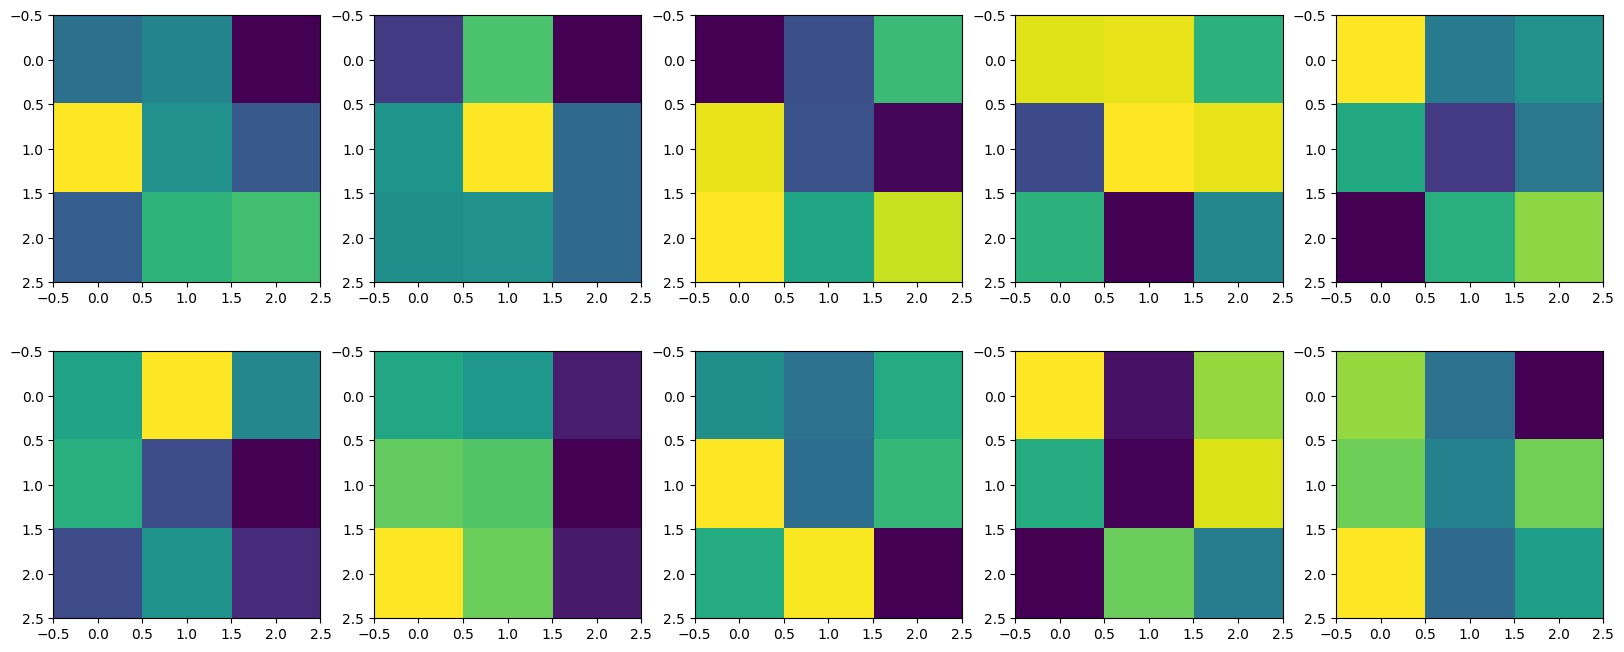

In [ ]:
# Get the weights in the first conv layer
weights = net.block_1[0].weight.data.cpu()
w = weights.numpy()

# for 10 filters
fig=plt.figure(figsize=(20, 8))
columns = 5
rows = 2
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(w[i][0])

print('First convolutional layer')
plt.show()

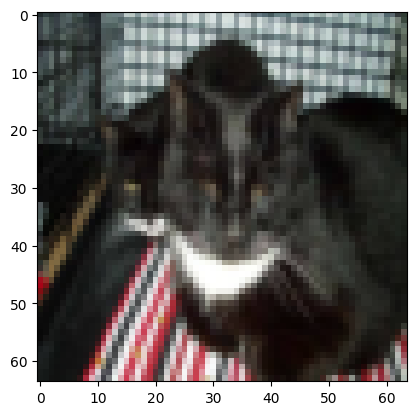

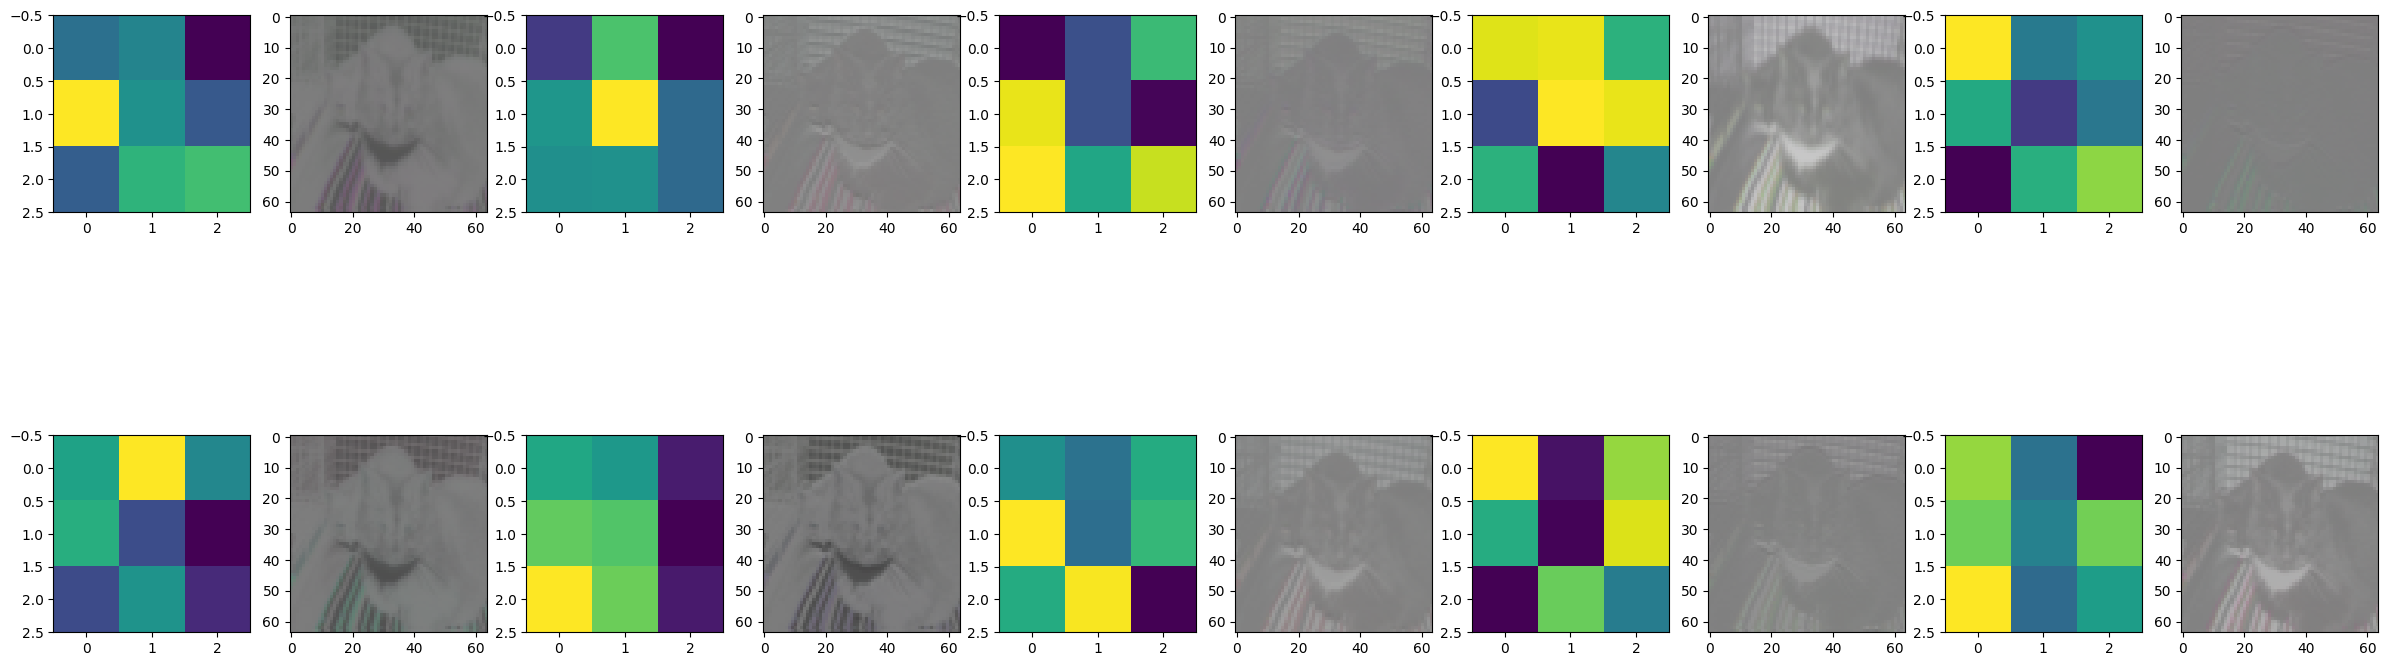

In [ ]:
# obtain one batch of testing images
dataiter = iter(test_loader)
images, labels = next(dataiter)
images = images.numpy()

# select an image by index
idx = 22
img = np.squeeze(images[idx])

import cv2
plt.imshow(img.transpose(1, 2, 0))

weights = net.block_1[0].weight.data.cpu()
w = weights.numpy()

fig=plt.figure(figsize=(30, 10))
columns = 5*2
rows = 2
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    if ((i%2)==0):
        plt.imshow(w[int(i/2)][0])
    else:
        c = cv2.filter2D(img, -1, w[int((i-1)/2)][0])
        c = c.transpose(1, 2, 0)
        c = c / 2 + 0.5
        plt.imshow(c)
plt.show()

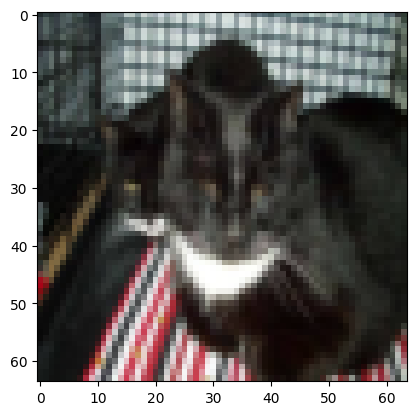

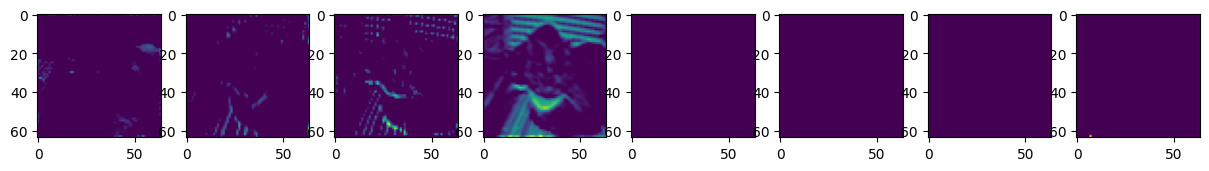

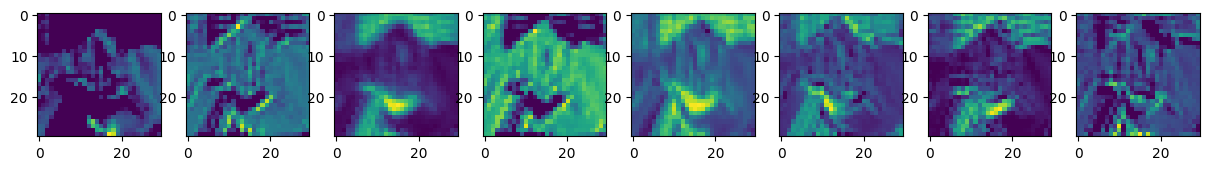

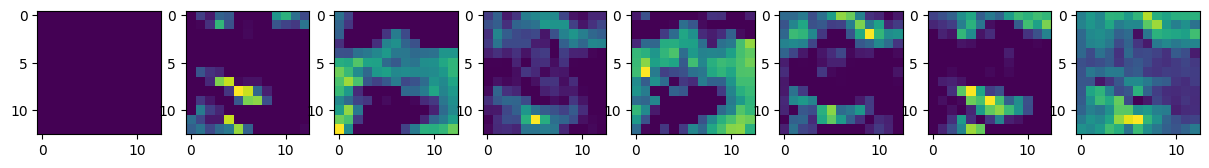

In [ ]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

net.block_1[0].register_forward_hook(get_activation('conv1'))
net.block_2[0].register_forward_hook(get_activation('conv2'))
net.block_3[0].register_forward_hook(get_activation('conv3'))

dataiter = iter(test_loader)
images, labels = next(dataiter)

img = images[22].to(device)
plt.imshow(img.permute(1, 2, 0).cpu())

data = img.unsqueeze_(0)
output = net(data)


act1 = activation['conv1'].squeeze().cpu()
act2 = activation['conv2'].squeeze().cpu()
act3 = activation['conv3'].squeeze().cpu()
acts = [act1, act2, act3]

j = 0
for i in range(1):
    for act in acts:
        f,(ax1,ax2,ax3,ax4, ax5, ax6, ax7, ax8) = plt.subplots(1, 8, sharex=True, figsize=(15,15))
        ax1.imshow(act[j])
        ax2.imshow(act[j+1])
        ax3.imshow(act[j+2])
        ax4.imshow(act[j+3])
        ax5.imshow(act[j+4])
        ax6.imshow(act[j+5])
        ax7.imshow(act[j+6])
        ax8.imshow(act[j+8])

        j = j+8

# Reference
https://www.learnpytorch.io/